In [2]:
# --- Import necessary libraries ---

import torch
import pandas as pd
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from peft import PeftModel
from PolymerSmilesTokenization import PolymerSmilesTokenizer
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import yaml

In [17]:
# --- Config ---
checkpoint_path = "ckpt/neurips.pt/Tg/Tg5"
num_properties = 1
blocksize = 411
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_csv = "data/neurips_augmented_test_Tg_norm.csv"  # This file should have true labels
finetune_config = yaml.load(open("config_finetune.yaml", "r"), Loader=yaml.FullLoader)

In [18]:
# --- Load Model & Tokenizer ---
base_model = RobertaForSequenceClassification.from_pretrained(
    finetune_config['model_path'],
    num_labels=num_properties,
    problem_type="regression"
)
model = PeftModel.from_pretrained(base_model, checkpoint_path)
model.to(device)
model.eval()

tokenizer = PolymerSmilesTokenizer.from_pretrained("roberta-base", max_len=blocksize)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ckpt/pretrain.pt and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'PolymerSmilesTokenizer'.


In [19]:
# --- Load Data ---
df = pd.read_csv(test_csv)
smiles_list = df["SMILES"].tolist()
ids = df["id"].tolist() if "id" in df.columns else list(range(len(df)))
true_labels = df.iloc[:, 1].values

In [20]:
# --- Inference ---
preds_list = []
with torch.no_grad():
    for smiles in smiles_list:
        encoding = tokenizer(
            str(smiles),
            add_special_tokens=True,
            max_length=blocksize,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze().cpu().numpy()
        preds_list.append(preds if num_properties > 1 else preds.item())

In [21]:
# --- Pearson Correlation ---
corr, _ = pearsonr(true_labels, preds_list)
print(f"Pearson correlation: {corr:.4f}")

Pearson correlation: 0.7849


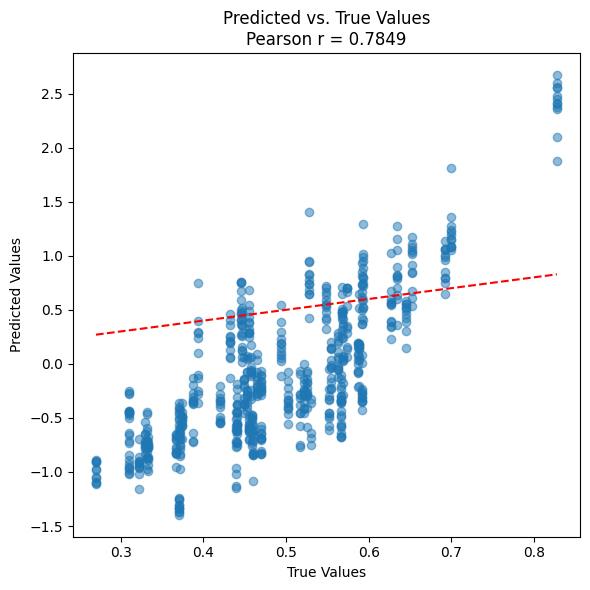

In [24]:
# --- Plot ---
plt.figure(figsize=(6, 6))
plt.scatter(true_labels, preds_list, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Predicted vs. True Values\nPearson r = {corr:.4f}")
plt.plot([min(true_labels), max(true_labels)], [min(true_labels), max(true_labels)], 'r--')
plt.tight_layout()
plt.show()

In [23]:
# --- Save Results ---
results_df = pd.DataFrame({
    "id": ids,
    "SMILES": smiles_list,
    "true_label": true_labels,
    "prediction": preds_list
})
results_df.to_csv("results/inference_results_with_correlation_Tg5.csv", index=False)
print("Inference and correlation complete. Results saved to inference_results_with_correlation_Tg5.csv.")

Inference and correlation complete. Results saved to inference_results_with_correlation_Tg5.csv.
